In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pytorchtools import CNN, GaussianNoise
from adversarialbox.attacks import FGSMAttack, LinfPGDAttack_AE, WassDROAttack_AE, L2PGDAttack_AE
from adversarialbox.train import adv_train, FGSM_train_rnd
from adversarialbox.utils import to_var, pred_batch, test
from layers_compress import Encoder, Generator, Quantizer, AutoencoderQ
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(32),
                                            torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST('../data/', download=True, train=True, transform=transform)                                 
mnist_test = torchvision.datasets.MNIST('../data/', download=True, train=False, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=10000, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=2500, shuffle=True)

In [3]:

def adv_distortion(model, eps, data):
    adversary = L2PGDAttack_AE(model=model, epsilon=eps, k=15, loss_fn=torch.nn.MSELoss())
    X_adv = adversary.perturb(data, None)
    return F.mse_loss(X_adv, model(X_adv)).item()*32*32

def eval_robust(model, epsilons, data):
    d = []
    for eps in epsilons:
        d += [adv_distortion(model, eps, torch.from_numpy(data).to(device))]
    return d

def awgn_distortion(model, variance, data):
    data_awgn = data + torch.randn(data.size(), device=device) * np.sqrt(variance)
    data_awgn = torch.clip(data_awgn, 0, 1)
    return F.mse_loss(data_awgn, model(data_awgn)).item()*32*32

def eval_awgn(model, variances, data):
    d = []
    for variance in variances:
        d += [awgn_distortion(model, variance, torch.from_numpy(data).to(device))]
    return d


In [4]:
data_orig = np.array([mnist_test[i][0].numpy() for i in range(len(mnist_test))])

In [6]:
noise_std = np.linspace(0., 0.25, 6)
epsilons = np.linspace(0, 10, 6)
L = 12

In [7]:
saved = torch.load(f'trained_no_robust/ae_c_d4L{L}.pt')
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
d = eval_robust(model, epsilons, data_orig)
d_awgn = eval_awgn(model, noise_std**2, data_orig)

In [7]:
saved = torch.load(f'trained_robust_L2PGD/ae_c_d4L{L}.pt')
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
d_L2 = eval_robust(model, epsilons, data_orig)
d_awgn_L2 = eval_awgn(model, noise_std**2, data_orig)

In [9]:
saved = torch.load(f'trained_robust_WassDRO/ae_c_d4L{L}.pt')
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
# d_WassDRO = eval_robust(model, epsilons, data_orig)
d_awgn_WassDRO = eval_awgn(model, noise_std**2, data_orig)

Text(0.5, 1.0, 'Distortion vs. $\\ell_2$ adversary (R=14.34 bits per image)')

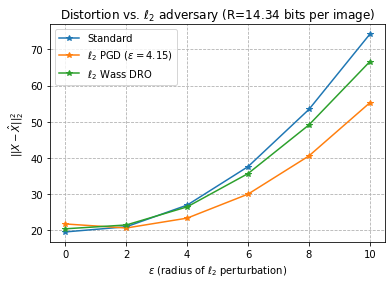

In [9]:
plt.figure()
plt.plot(epsilons, d, '-*')
plt.plot(epsilons, d_L2, '-*')
plt.plot(epsilons, d_WassDRO, '-*')
plt.legend(['Standard', r'$\ell_2$ PGD ($\epsilon=4.15$)', r'$\ell_2$ Wass DRO'])
plt.xlabel(r"$\epsilon$ (radius of $\ell_2$ perturbation)")
plt.ylabel(r"$|| X-\hat{X} ||_2^2$")
plt.grid(linestyle='--')
plt.title(f'Distortion vs. $\ell_2$ adversary (R={4*np.log2(L):.2f} bits per image)')
# plt.show()
# plt.savefig('plots/r20_l2adv.pdf')

$ X \sim \mathbb{P}_D$

$X+g \sim \mathbb{P}_D \star \mathcal{N}(0, \sigma^2 I)$

$W_2(\mathbb{P}_D \star \mathcal{N}(0, \sigma^2 I), \mathbb{P}_D) = \inf_{\pi\in \Pi(\mathbb{P}_D \star \mathcal{N}(0, \sigma^2 I), \mathbb{P}_D)} \mathbb{E}_\pi[\|g\|_2^2]^{1/2} \stackrel{?}{=} \sigma \sqrt{n}$

In [10]:
d_awgn_opt = []
for i, fname in enumerate(sorted(os.listdir('trained_optimal_gaussian'))):
    print(fname)
    saved = torch.load('trained_optimal_gaussian/' + fname)
    model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
    d_awgn_opt += [awgn_distortion(model, noise_std[i]**2, torch.from_numpy(data_orig).to(device))]

ae_c_d4L12_sigma0.0.pt
ae_c_d4L12_sigma0.05.pt
ae_c_d4L12_sigma0.1.pt
ae_c_d4L12_sigma0.15.pt
ae_c_d4L12_sigma0.2.pt
ae_c_d4L12_sigma0.25.pt


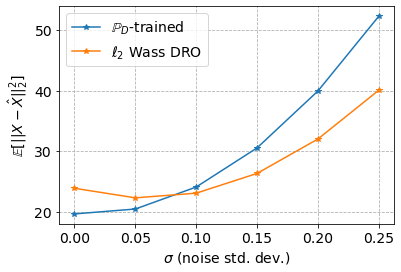

In [20]:
plt.rcParams.update({'font.size': 14})
plt.figure()
plt.plot(noise_std, d_awgn, '-*')
# plt.plot(noise_std, d_awgn_L2, '-*')
plt.plot(noise_std, d_awgn_WassDRO, '-*')
# plt.plot(noise_std, d_awgn_opt, '--*')
# plt.plot(noise_std, cert, '--*')
# plt.legend([r'$\mathbb{P}_D$-optimal code', r'$\ell_2$ PGD ($\epsilon=4.15$)', r'$\ell_2$ Wass DRO', r'$\mathbb{P}_D \star \mathcal{N}(0, \sigma^2 I)$-optimal code'])
plt.legend([r'$\mathbb{P}_D$-trained', r'$\ell_2$ Wass DRO'])
plt.xlabel(r"$\sigma$ (noise std. dev.)", )
plt.ylabel(r"$\mathbb{E}[|| X-\hat{X} ||_2^2]$")
plt.grid(linestyle='--')
# plt.title(f'Distortion vs. AWGN Noise (R={4*np.log2(L):.2f} bits per image)')
# plt.show()
plt.savefig('plots/r14_awgn_clean.pdf')

__Calculate Wasserstein Radius and Worst-case Certificate__

In [7]:
file = torch.load('wcd_cert/wcd_cert_gamma500.pt')
wcd = file['wcd']
cert = file['cert']

In [8]:
wcd = np.array(wcd)
cert = np.array(cert)

In [20]:
E = cert[0]
E

-2359.1197265625

Text(0.5, 1.0, 'Worst-Case Dist. & Cert. (R=14.34 bpi, $\\gamma = 0.36$)')

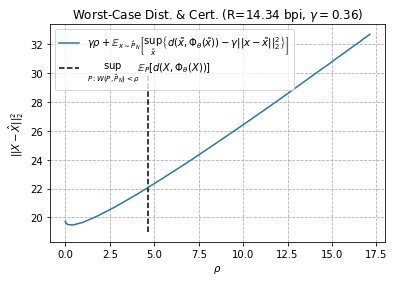

In [17]:
plt.figure()
# plt.plot(np.linspace(0., 18, 19), cert, '-')
plt.plot(wcd[:,0], wcd[:,1])
plt.xlabel(r"$\rho$")
plt.ylabel(r"$|| X-\hat{X} ||_2^2$")
plt.vlines(4.644, ymin=19, ymax=30, ls='--', color='k')
# plt.xlim([0, 18]) 
# plt.ylim([20, 29])
plt.legend([r'$\gamma\rho+\mathbb{E}_{x\sim\hat{P}_N}\left[\sup_\tilde{x} \left\{d(\tilde{x},\Phi_\theta(\tilde{x}))-\gamma || x-\tilde{x} ||_2^2 \right\}\right]$',
           r'$\sup_{P:W(P,\hat{P}_N)<\rho} \mathbb{E}_P[d(X, \Phi_\theta(X))]$',
           r'$\hat{\rho}_N(\theta) = 17.195$ (trained radius using $\gamma$)'])

plt.grid(linestyle='--')
plt.title(f'Worst-Case Dist. & Cert. (R={4*np.log2(L):.2f} bpi, ' + r'$\gamma = 0.36$)')
# plt.show()
# plt.savefig('plots/wcd_cert.pdf')

In [9]:
rhos = np.linspace(0, 17, 18)
noise_std = np.sqrt((1/1024)*rhos)
saved = torch.load(f'trained_gamma_sweep/ae_c_d4L{L}gamma500.pt')
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])
d_awgn_WassDRO = eval_awgn(model, noise_std**2, data_orig)

Text(0.5, 1.0, 'Worst-Case Dist. & Cert. (R=14.34 bpi, $\\gamma = 0.36$)')

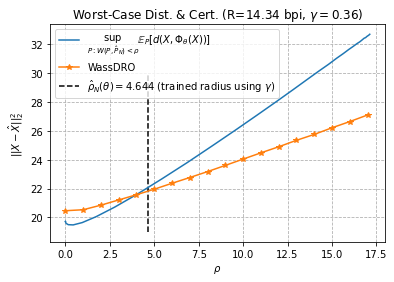

In [10]:
plt.figure()
# plt.plot(np.linspace(0., 18, 19), cert, '-')
plt.plot(wcd[:,0], wcd[:,1])
plt.plot(1024*noise_std**2, d_awgn_WassDRO, '-*')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$|| X-\hat{X} ||_2^2$")
plt.vlines(4.644, ymin=19, ymax=30, ls='--', color='k')
# plt.xlim([0, 18]) 
# plt.ylim([20, 29])
plt.legend([r'$\sup_{P:W(P,\hat{P}_N)<\rho} \mathbb{E}_P[d(X, \Phi_\theta(X))]$',
           'WassDRO',
           r'$\hat{\rho}_N(\theta) = 4.644$ (trained radius using $\gamma$)'])
# plt.legend([r'$\gamma\rho+\mathbb{E}_{x\sim\hat{P}_N}\left[\sup_\tilde{x} \left\{d(\tilde{x},\Phi_\theta(\tilde{x}))-\gamma || x-\tilde{x} ||_2^2 \right\}\right]$',
#            r'$\sup_{P:W(P,\hat{P}_N)<\rho} \mathbb{E}_P[d(X, \Phi_\theta(X))]$',
#            'WassDRO',
#            r'$\hat{\rho}_N(\theta) = 17.195$ (trained radius using $\gamma$)'])

plt.grid(linestyle='--')
plt.title(f'Worst-Case Dist. & Cert. (R={4*np.log2(L):.2f} bpi, ' + r'$\gamma = 0.36$)')

In [22]:
t = np.linspace(0., 50, 51)
gammas = 20000*0.85**t
gammas

array([2.00000000e+04, 1.70000000e+04, 1.44500000e+04, 1.22825000e+04,
       1.04401250e+04, 8.87410625e+03, 7.54299031e+03, 6.41154177e+03,
       5.44981050e+03, 4.63233893e+03, 3.93748809e+03, 3.34686487e+03,
       2.84483514e+03, 2.41810987e+03, 2.05539339e+03, 1.74708438e+03,
       1.48502172e+03, 1.26226847e+03, 1.07292820e+03, 9.11988967e+02,
       7.75190622e+02, 6.58912028e+02, 5.60075224e+02, 4.76063941e+02,
       4.04654349e+02, 3.43956197e+02, 2.92362767e+02, 2.48508352e+02,
       2.11232100e+02, 1.79547285e+02, 1.52615192e+02, 1.29722913e+02,
       1.10264476e+02, 9.37248047e+01, 7.96660840e+01, 6.77161714e+01,
       5.75587457e+01, 4.89249338e+01, 4.15861938e+01, 3.53482647e+01,
       3.00460250e+01, 2.55391212e+01, 2.17082531e+01, 1.84520151e+01,
       1.56842128e+01, 1.33315809e+01, 1.13318438e+01, 9.63206721e+00,
       8.18725713e+00, 6.95916856e+00, 5.91529327e+00])

In [6]:
# calc radius
from dro_tools import est_radius
gamma = 10
saved = torch.load(f'trained_annealed/ae_c_d4L12rho5.pt')
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

In [8]:
radius = est_radius(model, gamma, train_loader)
radius

16.616252899169922

In [7]:
test_loader = DataLoader(mnist_test, batch_size=200, shuffle=True)

In [8]:
radius = est_radius(model, gamma, test_loader)
radius

2.8043196249008178

In [9]:
data = torch.from_numpy(data_orig)

In [13]:
# calc wasserstein radius
adversary = WassDROAttack_AE(model=model, a=1., gamma=10, k=30, loss_fn=nn.MSELoss(), transport_cost=nn.MSELoss())
X_adv = adversary.perturb(data.to(device), None)

In [14]:
radius = F.mse_loss(X_adv, data.to(device)).item()*32*32

In [15]:
radius

16.601892471313477

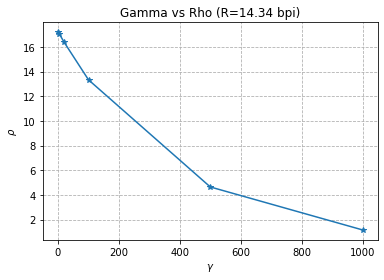

In [67]:
#gamma vs. rho
gammas = [1000, 500, 100, 20, 4, 0.36]
rhos = [1.159, 4.644, 13.335, 16.383, 17.066, 17.195]

plt.figure()
plt.plot(gammas, rhos, '-*')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\rho$')
plt.grid(linestyle='--')
plt.title(f'Gamma vs Rho (R={4*np.log2(L):.2f} bpi)')
# plt.savefig('plots/gamma_vs_rho.pdf')